In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv('nba-player-stats-2021.csv', encoding='ISO-8859-1')
data.head()

,player,pos,age,tm,g,gs,mp,fg,fga,fgpercent,...,drb,trb,ast,stl,blk,tov,pf,pts,ortg,drtg
0,Precious Achiuwa,C,22,TOR,73,28,1725,7.7,17.5,0.439,...,9.5,13.7,2.4,1.1,1.2,2.4,4.4,19.2,105.0,110
1,Steven Adams,C,28,MEM,76,75,1999,5.0,9.2,0.547,...,9.8,18.2,6.1,1.6,1.4,2.8,3.7,12.6,125.0,108
2,Bam Adebayo,C,24,MIA,56,56,1825,11.1,20.0,0.557,...,11.7,15.5,5.2,2.2,1.2,4.1,4.7,29.3,117.0,104
3,Santi Aldama,PF,21,MEM,32,0,360,7.0,17.5,0.402,...,7.2,11.6,2.8,0.8,1.3,2.1,4.8,17.5,101.0,111
4,LaMarcus Aldridge,C,36,BRK,47,12,1050,11.6,21.1,0.550,...,8.5,11.9,1.9,0.6,2.2,2.0,3.6,28.0,119.0,112


In [3]:
data = data.rename(columns={'player':'Player', 'pos':'Position', 'age':'Age', 'tm':'Team', 'g':'N_Games', 
                            'gs':'Game_Started', 'mp':'Minute_played', 'fg':'Field_goal', 'fga':'Goal_attempt', 
                            'fgpercent':'Field_goal%',
                            'x3p':'3points_scored', 'x3pa':'3points_Assists', 'x3ppercent':'3points%', 'x2p':'2points_scored', 
                            'x2pa':'2points_assits',
                            'x2ppercent':'2points%', 'ft':'FreeThrow', 'fta':'FreeThrowAttempt',
                            'ftpercent':'FreeThrow%', 'orb':'OffensiveRebound', 'drb':'DenffesiveRebound', 'trb':'TotalRebound', 
                            'ast':'Assists', 'stl':'Steal', 'blk':'Blocks', 'tov':'TurnOver', 'pf':'PersonalFoul',
                            'pts':'Points', 'ortg':'OffensiveRating', 'drtg':'DeffensiveRating'})

### Basic understanding of data

In [4]:
print(data.describe())

              Age     N_Games  Game_Started  Minute_played  Field_goal  \
count  812.000000  812.000000    812.000000     812.000000  812.000000   
mean    26.051724   36.705665     16.672414     825.188424    6.935468   
std      4.059640   25.898042     23.817195     775.786331    3.419585   
min     19.000000    1.000000      0.000000       1.000000    0.000000   
25%     23.000000   12.000000      0.000000     121.000000    5.100000   
50%     25.000000   36.500000      4.000000     577.500000    6.850000   
75%     29.000000   61.000000     25.000000    1414.500000    8.600000   
max     41.000000   82.000000     82.000000    2854.000000   49.000000   

       Goal_attempt  Field_goal%  3points_scored  3points_Assists    3points%  \
count    812.000000   797.000000      812.000000       812.000000  740.000000   
mean      16.066995     0.434257        2.028695         6.467611    0.303445   
std        5.627889     0.137794        1.573494         4.443072    0.138111   
min      

In [5]:
print(f'Duplicate entries: {data.duplicated().sum()} \nNull values: \n{data.isna().sum()}')

Duplicate entries: 0 
Null values: 
Player                0
Position              0
Age                   0
Team                  0
N_Games               0
Game_Started          0
Minute_played         0
Field_goal            0
Goal_attempt          0
Field_goal%          15
3points_scored        0
3points_Assists       0
3points%             72
2points_scored        0
2points_assits        0
2points%             28
FreeThrow             0
FreeThrowAttempt      0
FreeThrow%           97
OffensiveRebound      0
DenffesiveRebound     0
TotalRebound          0
Assists               0
Steal                 0
Blocks                0
TurnOver              0
PersonalFoul          0
Points                0
OffensiveRating      10
DeffensiveRating      0
dtype: int64


In [6]:
data.shape

(812, 30)

In [7]:
# Drop all row with duplicate players
data = data.drop_duplicates(subset=['Player'])
data.shape

(605, 30)

In [8]:
# Fill all missing data with the most frequent rather than droping them since this is a small dataset
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

## Exploratory Data Analysis (EDA)

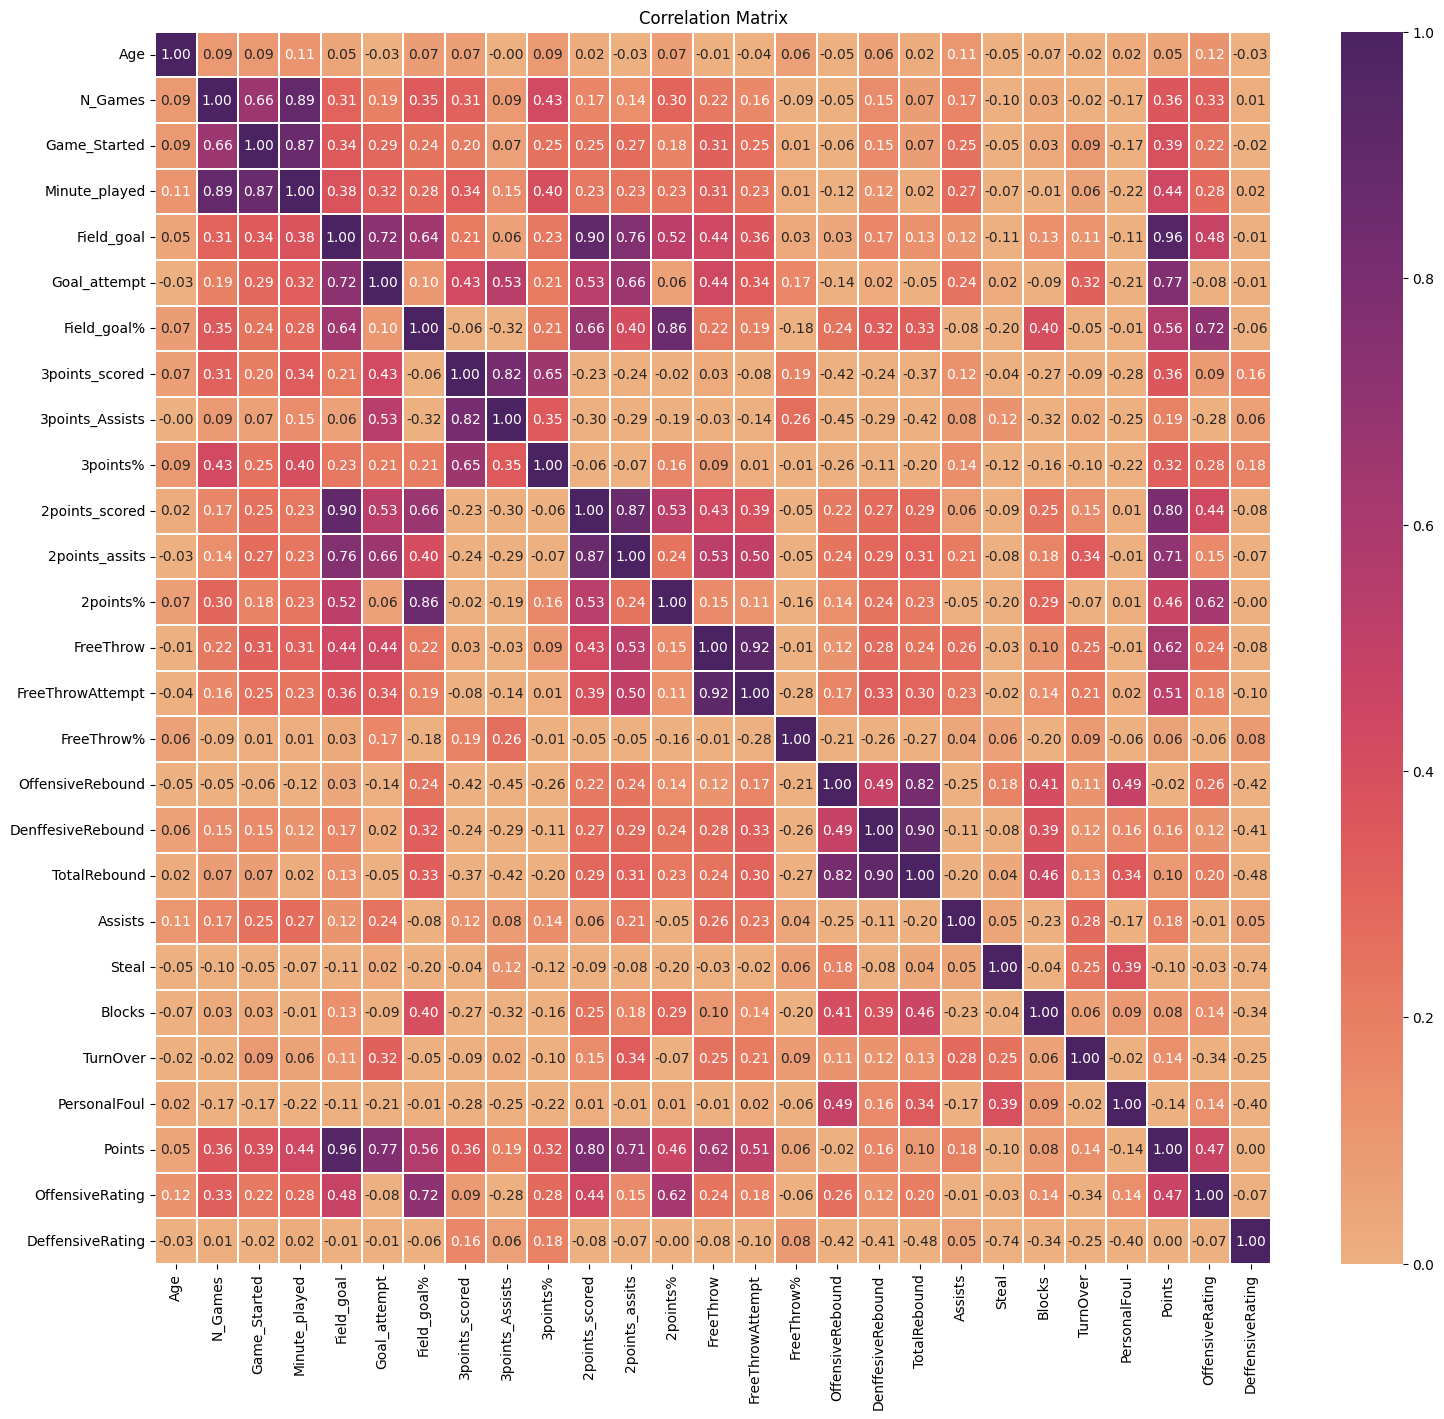

In [9]:
# Create a heatmap to see how our feature are interacting with one another

plt.figure(figsize=(18,16))
corr = data.drop(columns=['Player', 'Position', 'Team']).corr(method='pearson')
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=1,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.title('Correlation Matrix')
plt.show()

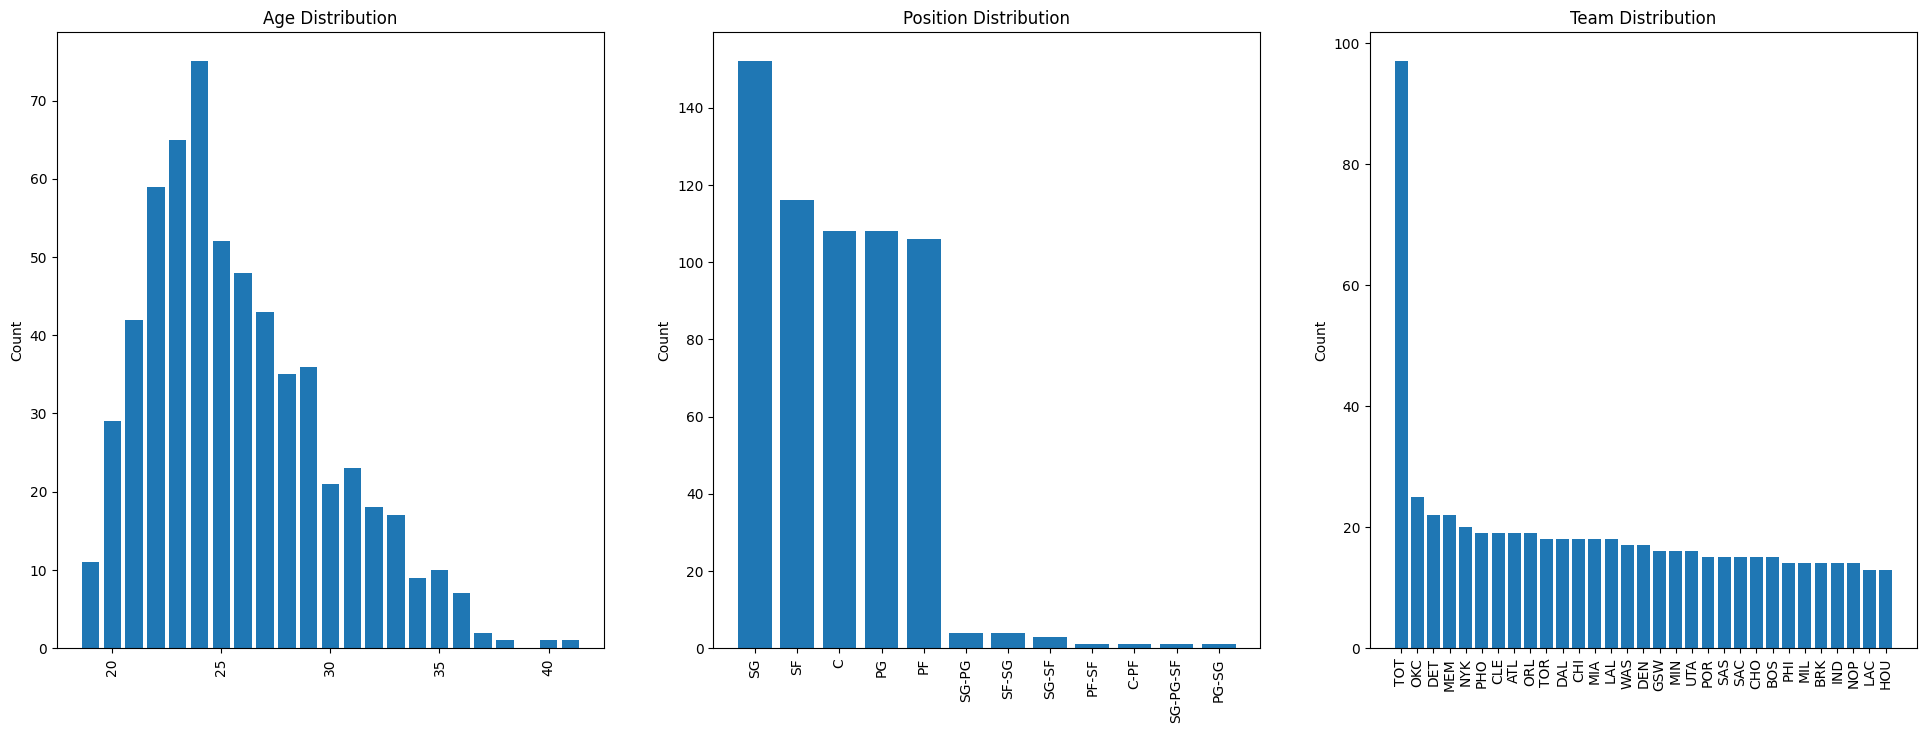

In [10]:
# Create a figure and subplots to plot all categorical variable distribution
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
variables = ['Age', 'Position', 'Team']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var.capitalize()} Distribution')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)

In [11]:
y = data['Position']

# Remove all lower classes in our target variable
class_count = y.value_counts()
rare_class = [cls for cls, count in class_count.items() if count <=4]
new_class_indice = [i for i, label in enumerate(y) if label not in rare_class]

data = data.iloc[new_class_indice]

## Feature Engineering

In [12]:
# create some feature engineering
data['Avg_Rating'] = (data['OffensiveRating'] + data['DeffensiveRating'])/2
data['Avg_Rebound'] = (data['OffensiveRebound'] + data['DenffesiveRebound'])/2

# Drop features that are not relevent to our study
data = data.drop(columns=['Team'])

##### Identify and Remove outliers

/var/folders/v_/4h5_dq7j1d92_55cg8fcss000000gn/T/ipykernel_3209/806505450.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


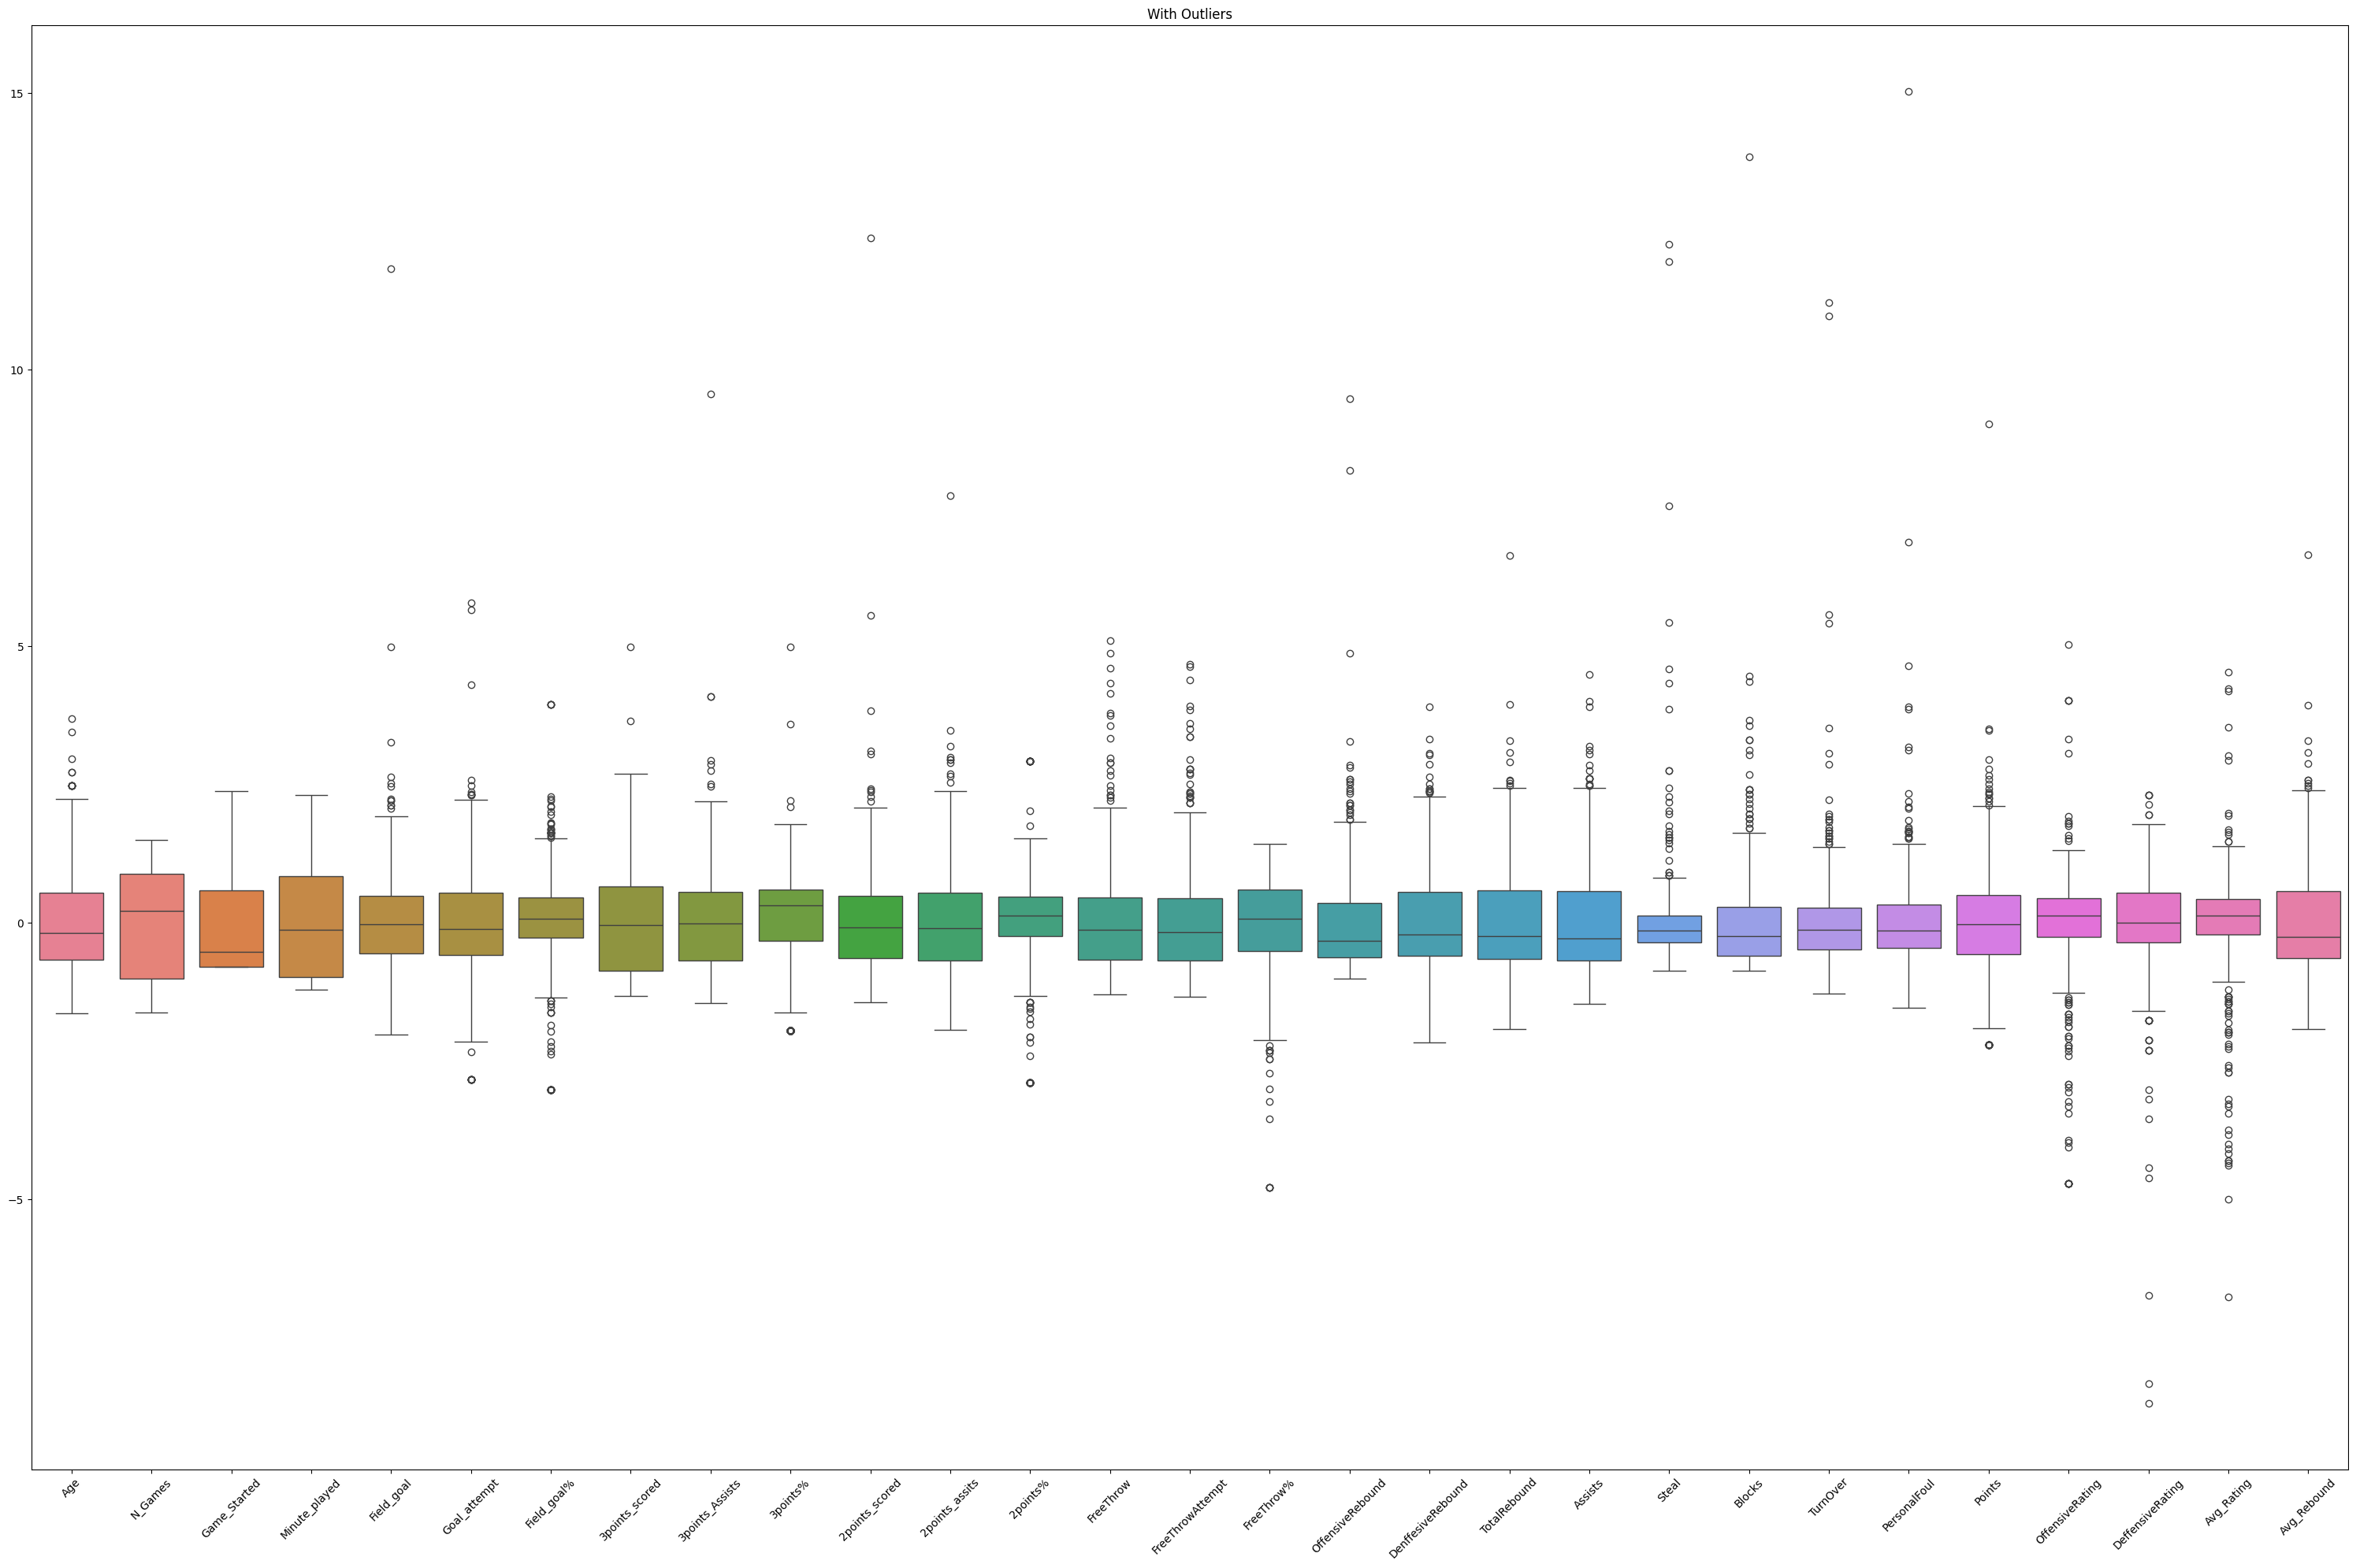

In [13]:
# Get all the numerical columns and scale them
features = [col for col in data.columns if col not in ['Position', 'Player','Age_Binned']]
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Plot Boxplot
fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('With Outliers')
plt.tight_layout()
plt.show()

/var/folders/v_/4h5_dq7j1d92_55cg8fcss000000gn/T/ipykernel_3209/2772015398.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


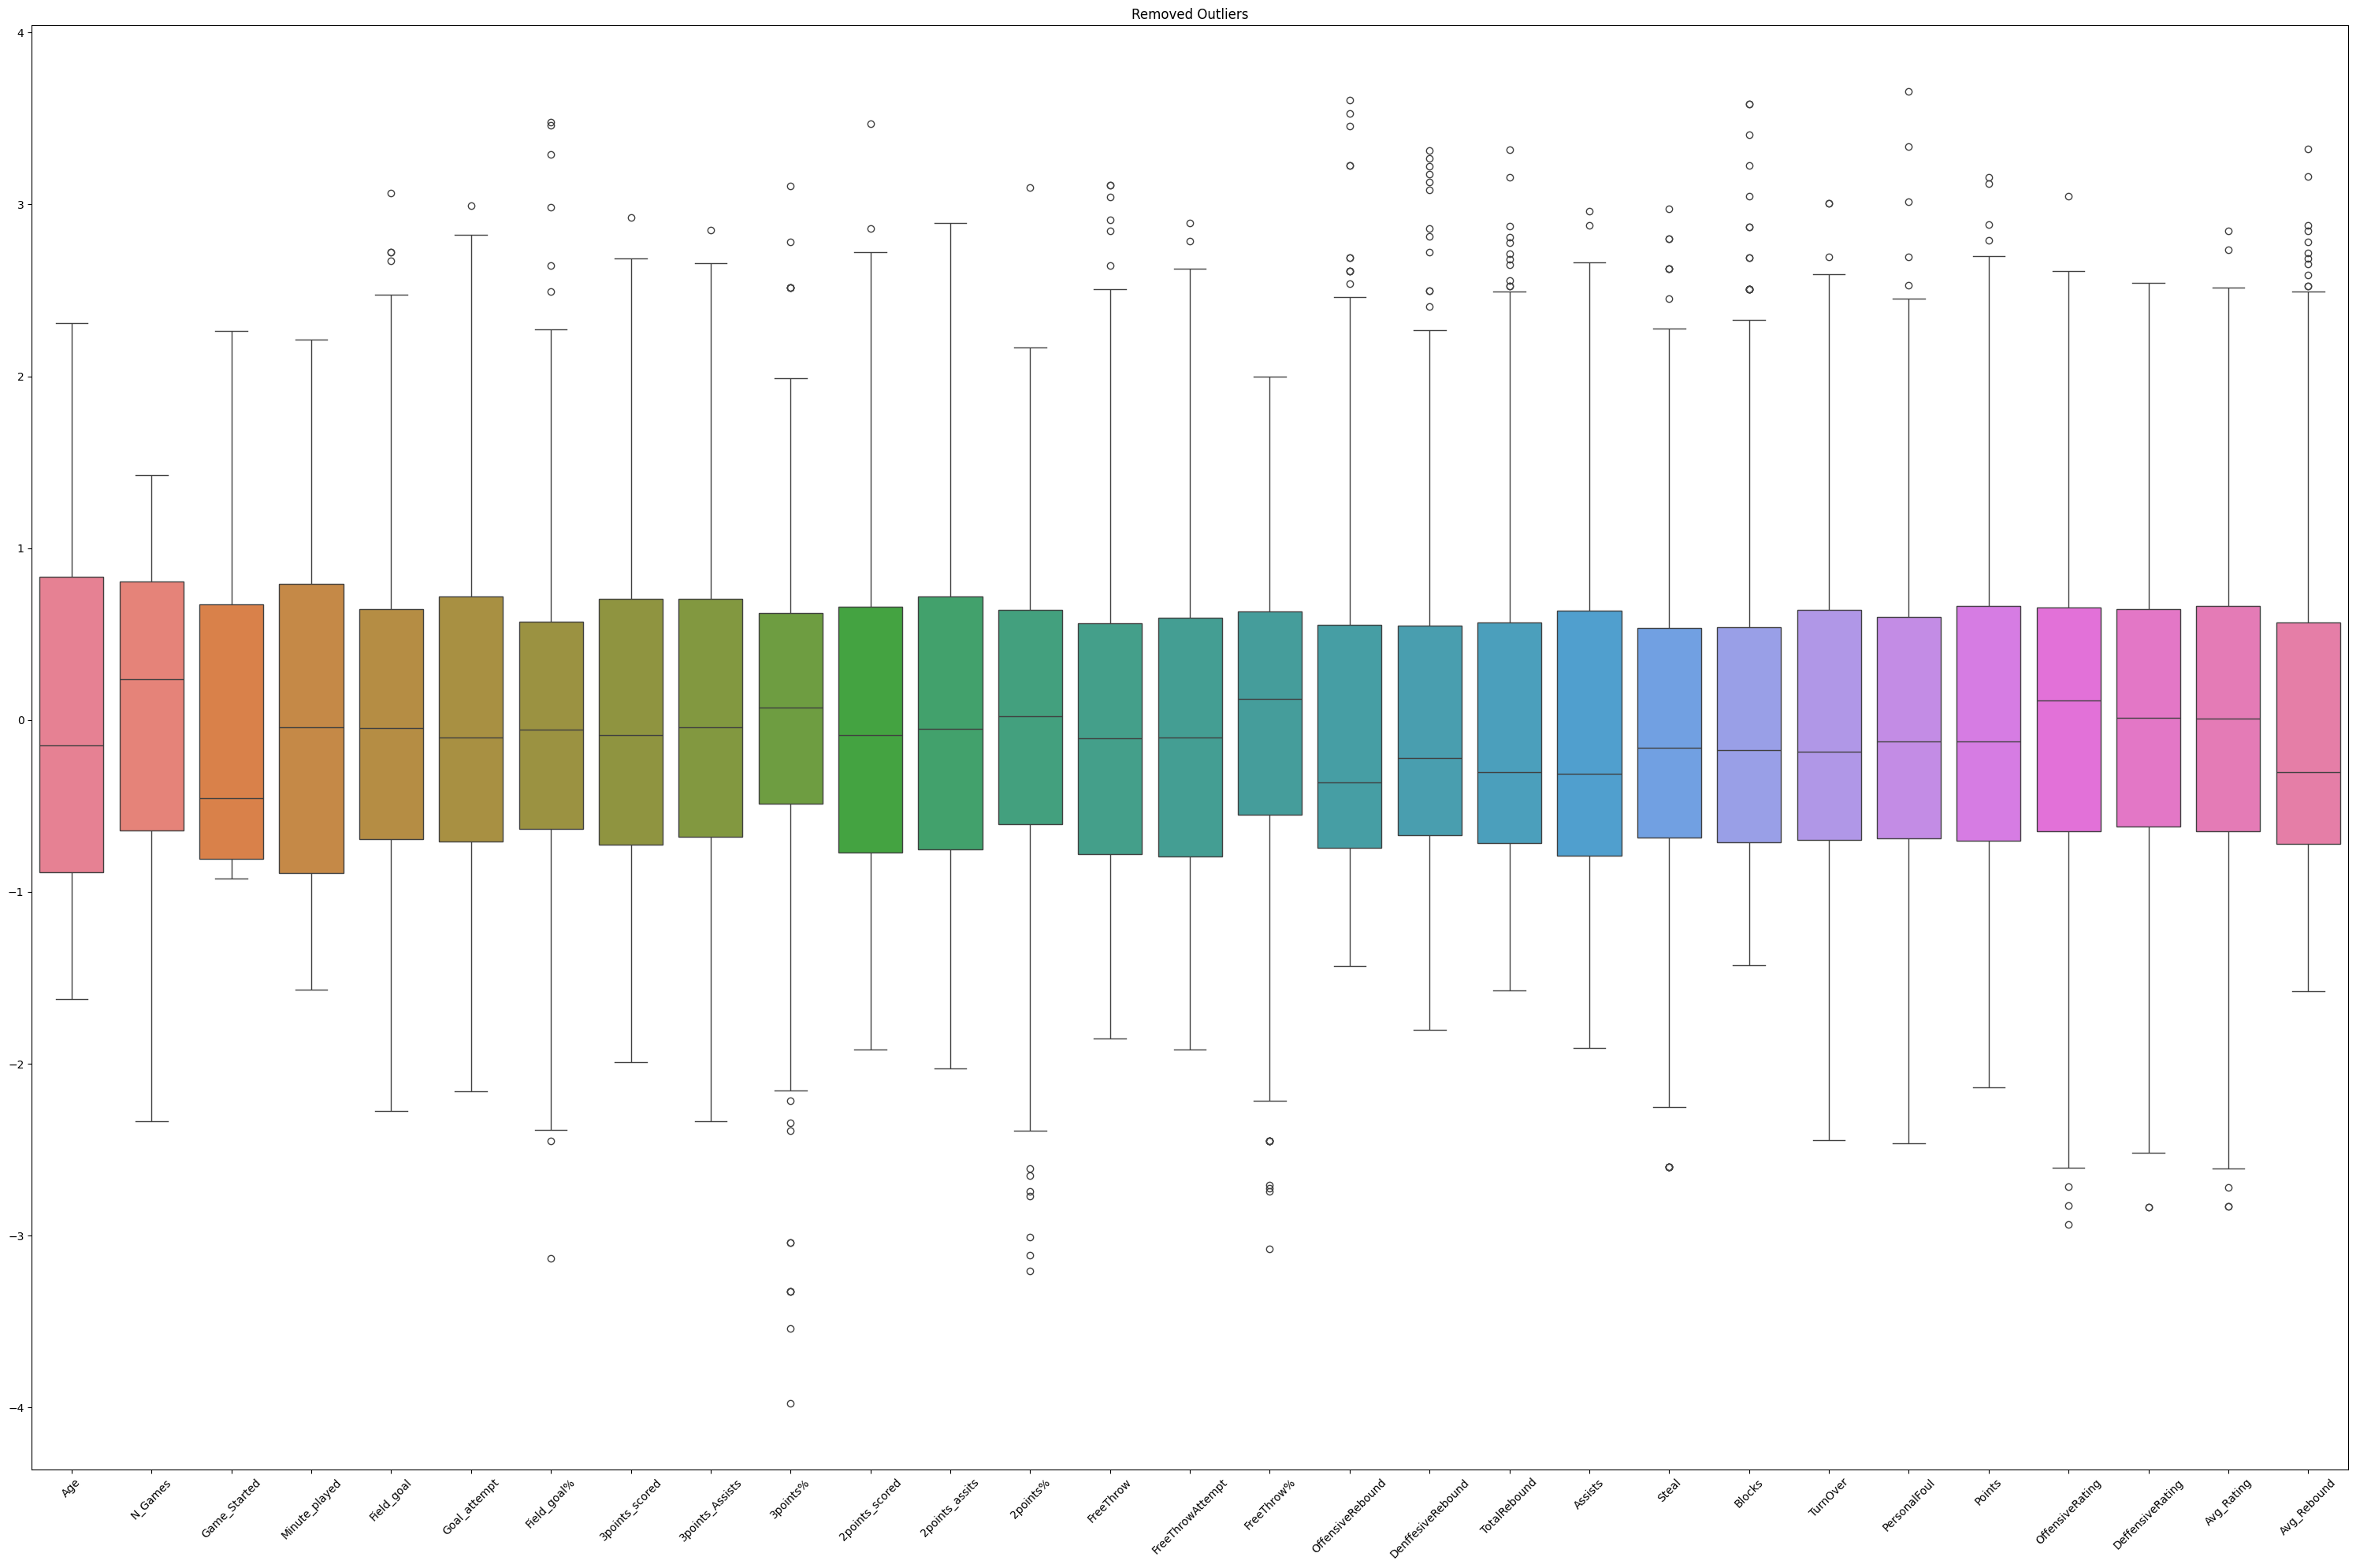

In [14]:
# Calculate outliers
Q1 = scaled_data.quantile(0.25)
Q3 = scaled_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers and mask it to the original data
mask = ~((scaled_data < lower_bound) | (scaled_data > upper_bound)).any(axis=1)
filtered_data = data[mask].copy()

# scale the data and put on the dataframe to make easy to visualize
filtered_scaled_data = pd.DataFrame(scaler.fit_transform(filtered_data[features]), columns=features, index=filtered_data.index)

# boxplot
fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=filtered_scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Removed Outliers')
plt.tight_layout()
plt.show()

### Principal Component Analysis (PCA)

In [15]:
# Instanciate and fit pca
pca = PCA(n_components=10, random_state=42)  
pca_components = pca.fit_transform(filtered_scaled_data)

# Create a label for the PCA columns
labels = [f'PC{i+1}' for i in range(pca.n_components_)]

# put the pca into a dataframe
pca_df = pd.DataFrame(pca_components, columns=labels)

# merge the filtered data with the pca data to indentify player performances based on their variances
pca_merged = pd.concat([filtered_data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# Identify top and bottom players on PCA 1
top_players = pca_merged.sort_values(by='PC1', ascending=False).head(15)
bottom_players = pca_merged.sort_values(by='PC1', ascending=True).head(15)

# Top / bottom feature contribution based on PCA 1
top_features = top_players[features]
bottom_features = bottom_players[features]

# Get the mean of each feature
mean_top_features = top_features.mean()
mean_bottom_features = bottom_features.mean()

# create a dataframe for comparison
feature_comparison = pd.DataFrame({
    'Top Performers': mean_top_features,
    'Bottom Performers': mean_bottom_features
})

# Print top players
print(top_players[['Player','Age','Field_goal%','PC1']])

print(feature_comparison.head(10))

                  Player Age Field_goal%       PC1
345  Jonas ValanÄiÅ«nas  29       0.544  8.318119
343   Karl-Anthony Towns  26       0.529  8.273607
12         Deandre Ayton  23       0.634  8.020961
309     Domantas Sabonis  25       0.573  7.571184
139     Montrezl Harrell  28       0.645  7.422051
71        Brandon Clarke  25       0.644  6.852951
331         Jayson Tatum  23       0.453  6.584736
316        Pascal Siakam  27       0.494  6.379467
294        Julius Randle  27       0.411  5.614400
380       Christian Wood  26       0.501  5.580332
163       Brandon Ingram  24       0.461  5.539136
65    Wendell Carter Jr.  22       0.525  5.494160
39          Devin Booker  25       0.466  5.464489
105         Drew Eubanks  24       0.596  5.389534
86        Dewayne Dedmon  32       0.566  5.293341
                Top Performers Bottom Performers
Age                  25.733333              25.8
N_Games              67.333333         24.933333
Game_Started         52.266667       

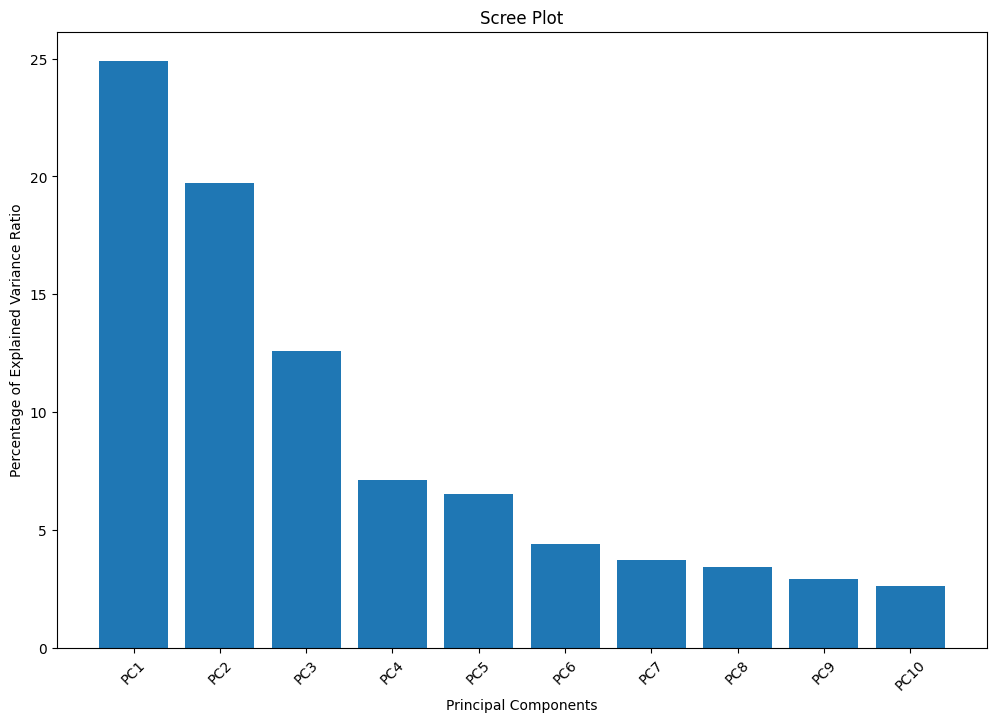

In [16]:
# Plot the loading distributions
exp_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.figure(figsize=(12,8))
plt.bar(range(1, len(exp_var)+1), height=exp_var, tick_label=labels)

plt.ylabel('Percentage of Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.xticks(rotation=45)
plt.show()

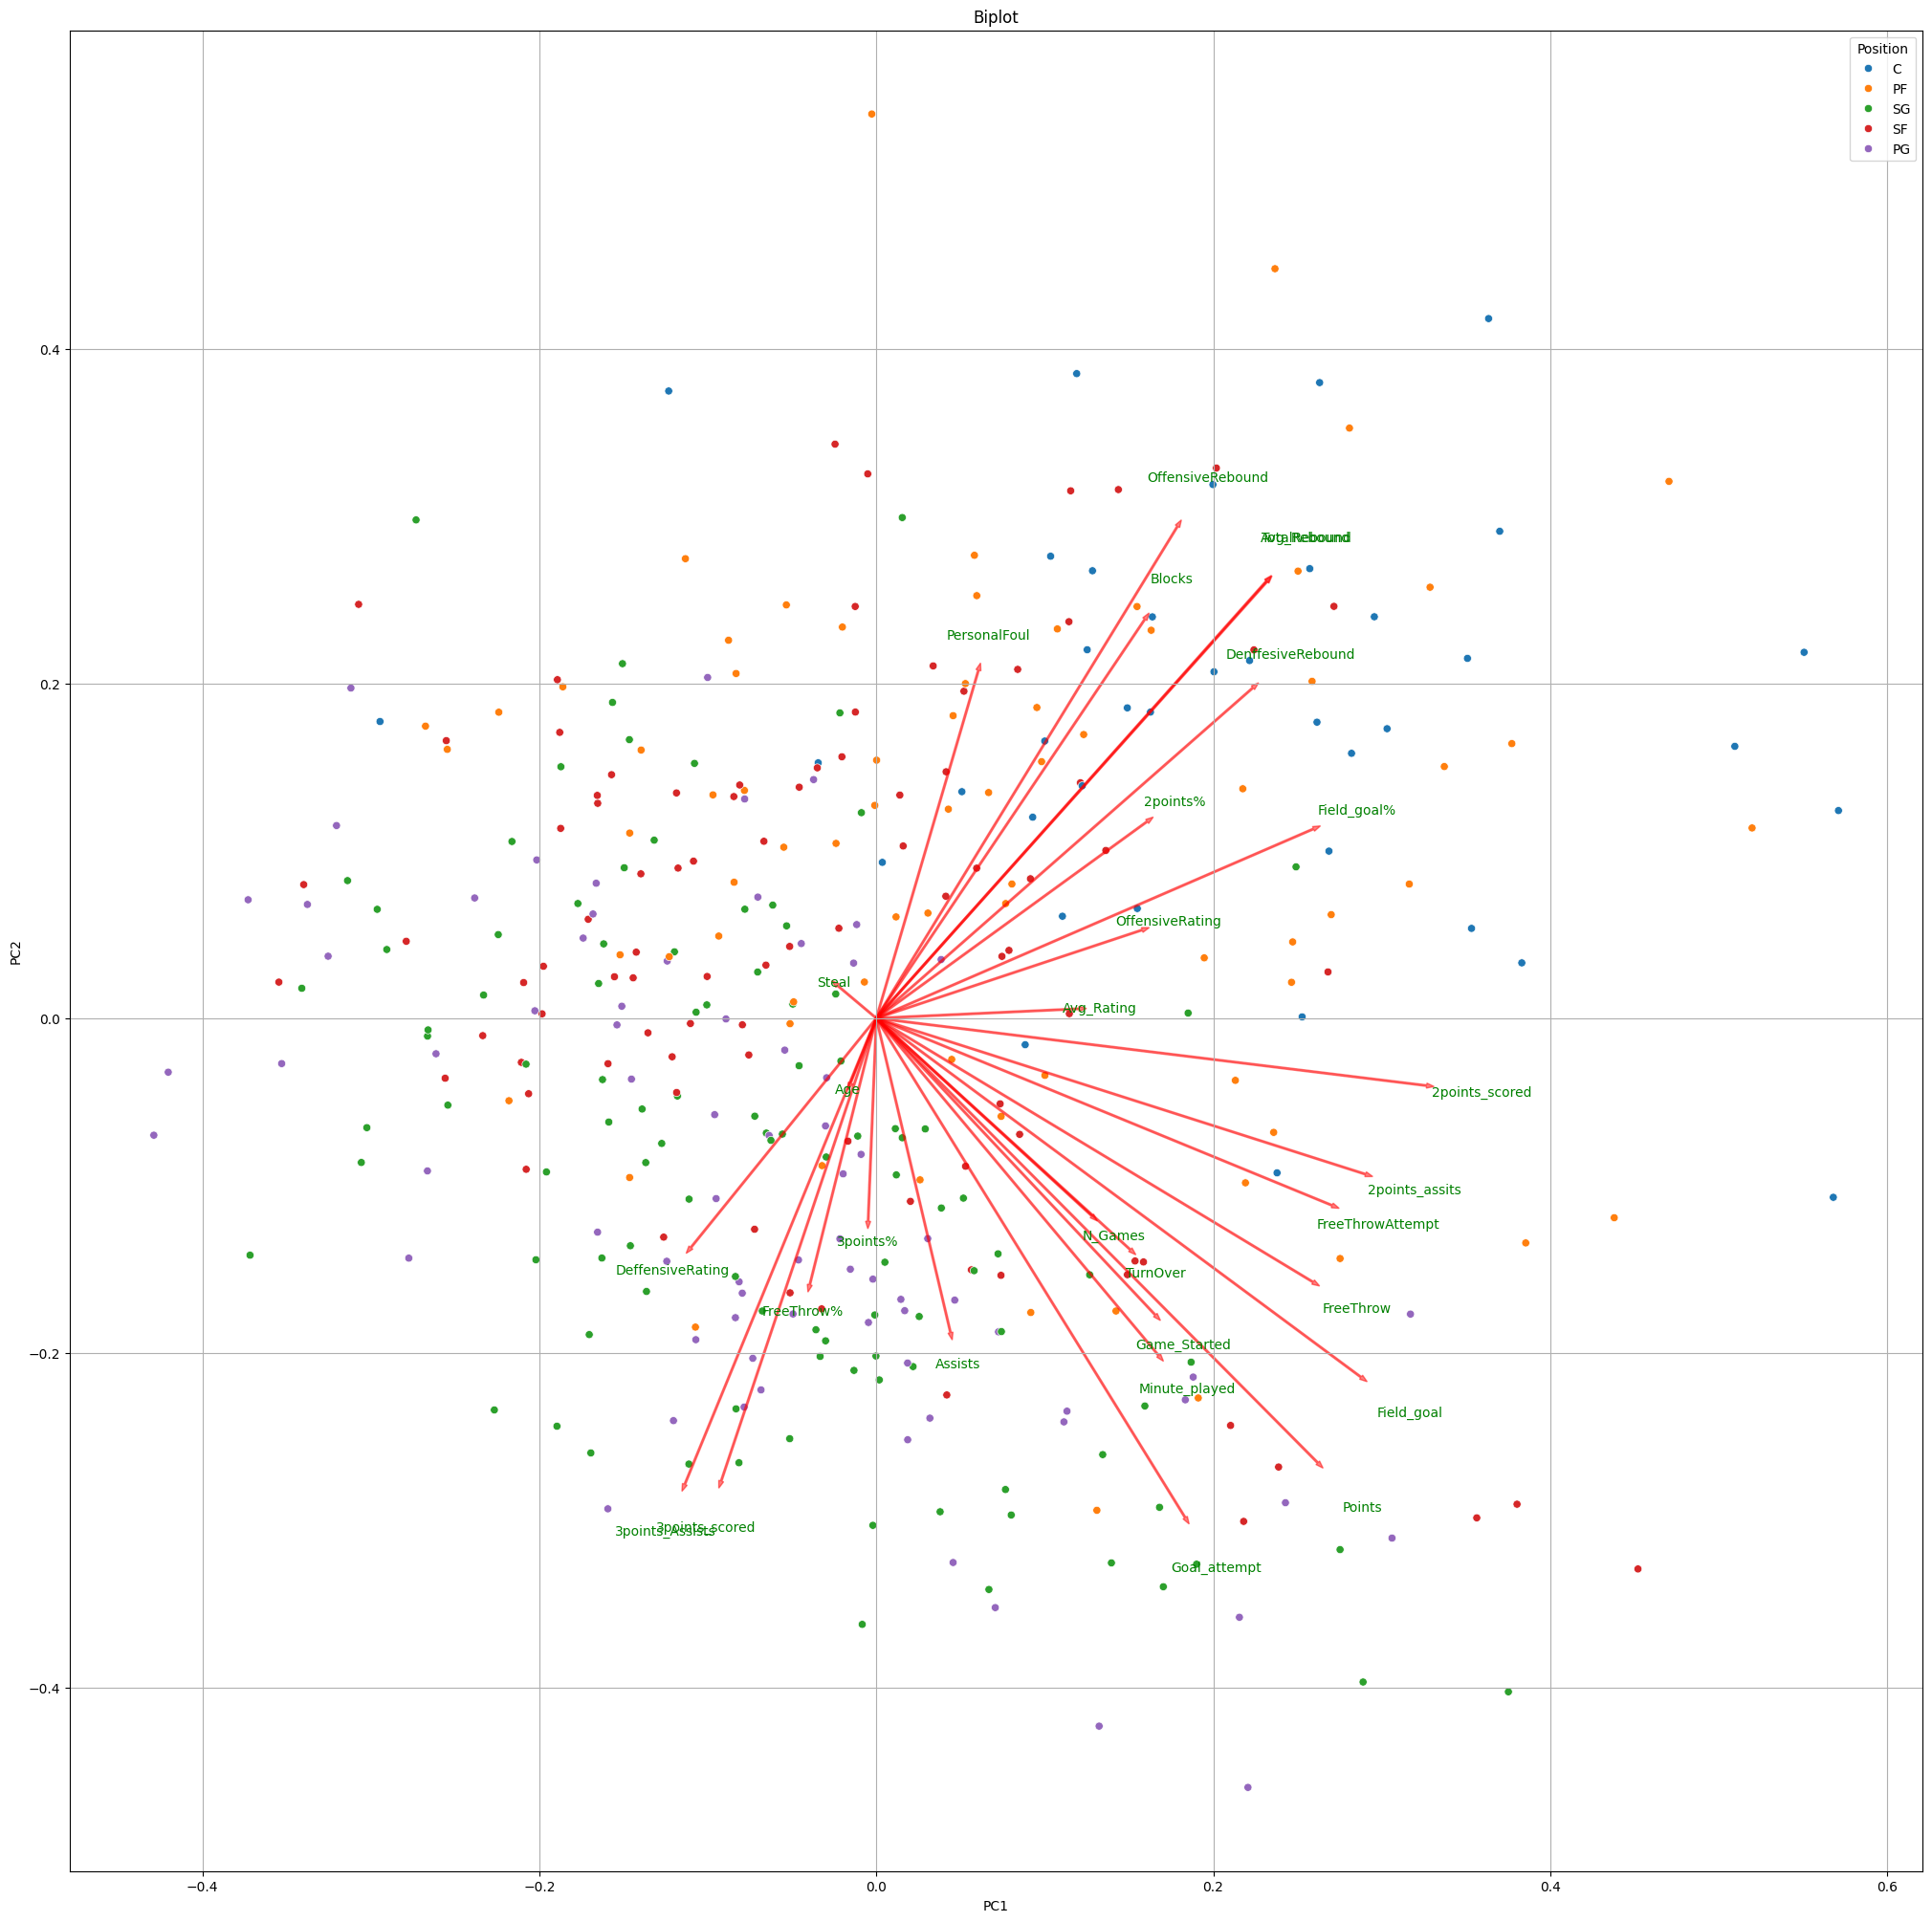

In [17]:
y = pca_merged['Position']

def myplot(score, coeff, labels, y):
    pc1 = score['PC1']
    pc2 = score['PC2']
    n = coeff.shape[0]
    # Scale the x and y to make the loadings easier to see
    scalex = 1/(pc1.max() - pc1.min())
    scaley = 1/(pc2.max() - pc2.min())
    plt.figure(figsize=(25,25))
    sns.scatterplot(x=pc1 * scalex, y=pc2 * scaley, hue=y)
    for i in range(n):
        # Plot an arrow for each component weight
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        # Plot the name of the component (use 1.15 to plot the text slightly above the arrow)
        plt.text(coeff[i, 0] * 1.1, coeff[i, 1] * 1.1,
                 labels[i], color='g', ha='center', va='center')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title('Biplot')
    plt.grid()
    
    plt.show()
# Call the function. Use only the 2 PCs. 
myplot(pca_df, np.transpose(pca.components_), features, y)

#### Feature importance for classification

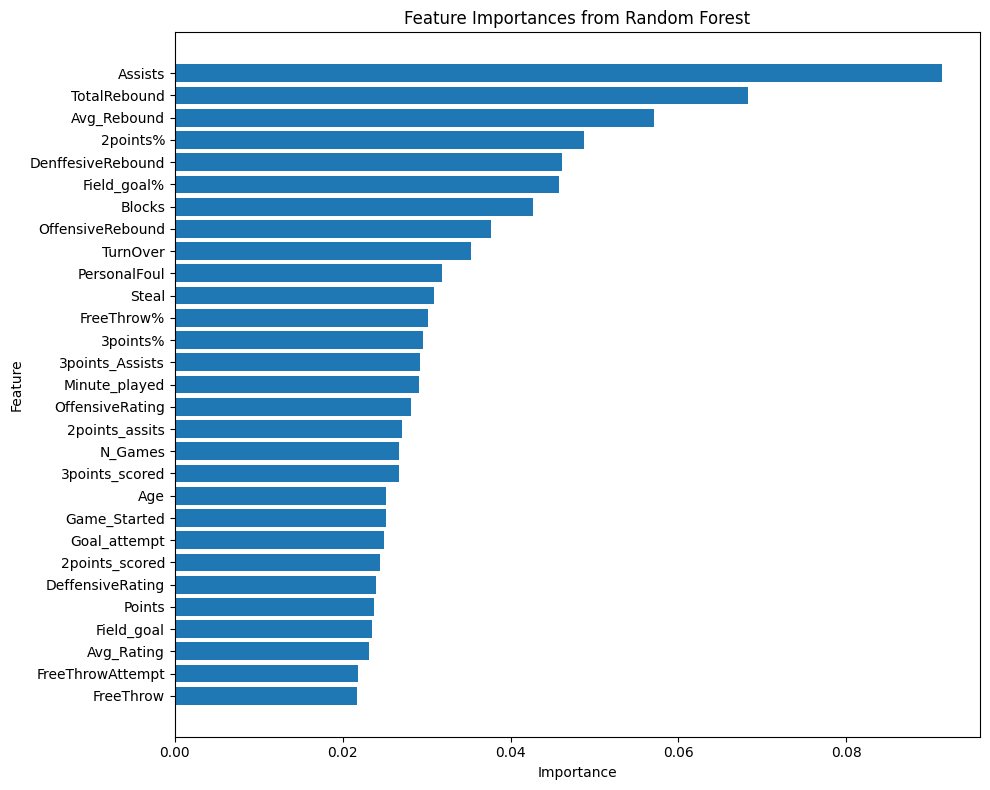

In [18]:
# create feature and target variables
X = filtered_data.drop(columns=['Position', 'Player'])
y = filtered_data['Position']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciate and fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create a DataFrame for feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,8))
plt.barh(importances['Feature'], importances['Importance'] )
plt.title("Feature Importances from Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# More Feature Engineering

In [19]:
# Interaction features
filtered_data['Points_per_Minute'] = filtered_data['Points'] / filtered_data['Minute_played']

# Polynomial features
filtered_data['Field_goal%_squared'] = filtered_data['Field_goal%'] ** 2
filtered_data['Avg_Rating_squared'] = filtered_data['Avg_Rating'] ** 2

# Aggregated statistics
filtered_data['Rolling_Points_Avg'] = filtered_data['Points'].rolling(window=5).mean()
filtered_data['Rolling_Assists_Max'] = filtered_data['Assists'].rolling(window=5).max()

# Cross Features
filtered_data['Cross_2points_scored_assist'] = filtered_data['2points_assits'] * filtered_data['2points_scored']
filtered_data['Cross_3points_scored_assist'] = filtered_data['3points_Assists'] * filtered_data['3points_scored']
filtered_data['Ratings'] = filtered_data['DeffensiveRating'] * filtered_data['OffensiveRating']

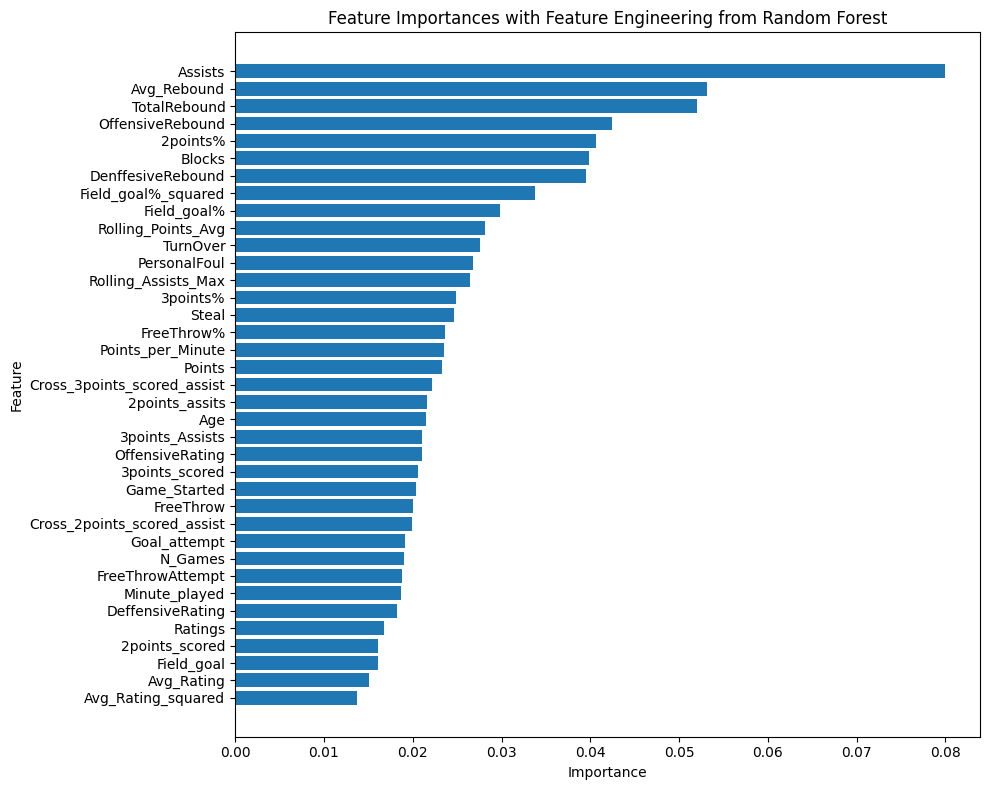

In [20]:
# create feature and target variables
X = filtered_data.drop(columns=['Position', 'Player'])
y = filtered_data['Position']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciate and fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create a DataFrame for feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,8))
plt.barh(importances['Feature'], importances['Importance'] )
plt.title("Feature Importances with Feature Engineering from Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
# fill and NA values based on the feature engineering and reset the index
filtered_data = filtered_data.fillna(0)
filtered_data = filtered_data.reset_index(drop=True)

/var/folders/v_/4h5_dq7j1d92_55cg8fcss000000gn/T/ipykernel_3209/122167782.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_data = filtered_data.fillna(0)


## Model Training, Test and Evaluation

In [22]:
# Top 34 features
importances['Feature'].head(34).values

array(['Assists', 'Avg_Rebound', 'TotalRebound', 'OffensiveRebound',
       '2points%', 'Blocks', 'DenffesiveRebound', 'Field_goal%_squared',
       'Field_goal%', 'Rolling_Points_Avg', 'TurnOver', 'PersonalFoul',
       'Rolling_Assists_Max', '3points%', 'Steal', 'FreeThrow%',
       'Points_per_Minute', 'Points', 'Cross_3points_scored_assist',
       '2points_assits', 'Age', '3points_Assists', 'OffensiveRating',
       '3points_scored', 'Game_Started', 'FreeThrow',
       'Cross_2points_scored_assist', 'Goal_attempt', 'N_Games',
       'FreeThrowAttempt', 'Minute_played', 'DeffensiveRating', 'Ratings',
       '2points_scored'], dtype=object)

Using KFold strategy: StratifiedKFold_3
Classifier: SVC
Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best Score: 0.5228758169934641
Best Parameters: {'svc__C': 1, 'svc__degree': 1, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}
              precision    recall  f1-score   support

           C       0.42      0.62      0.50         8
          PF       0.25      0.31      0.28        13
          PG       0.60      0.69      0.64        13
          SF       0.17      0.11      0.13        18
          SG       0.59      0.52      0.55        25

    accuracy                           0.43        77
   macro avg       0.40      0.45      0.42        77
weighted avg       0.42      0.43      0.42        77

---------------------------------------------------------------------------
Classifier: RandomForestClassifier
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Score: 0.5
Best Parameters: {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_dept

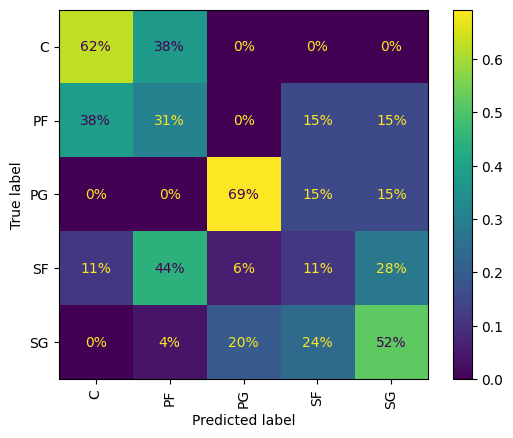

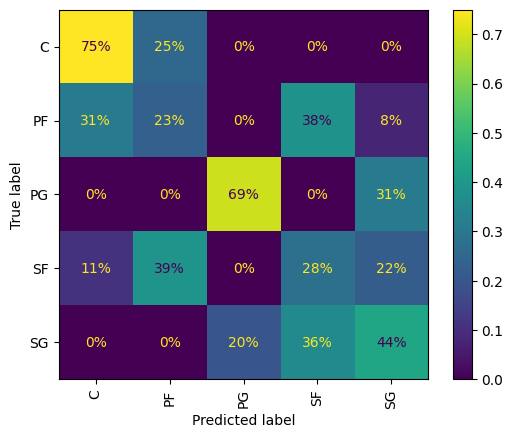

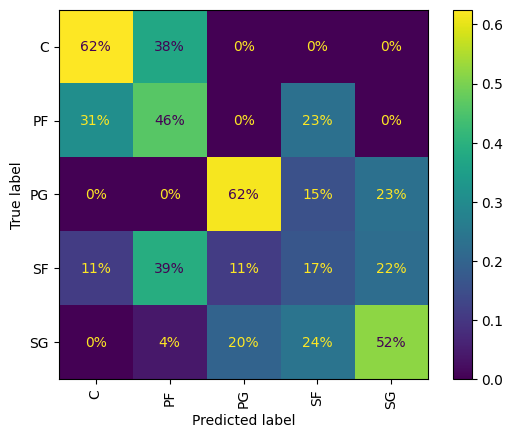

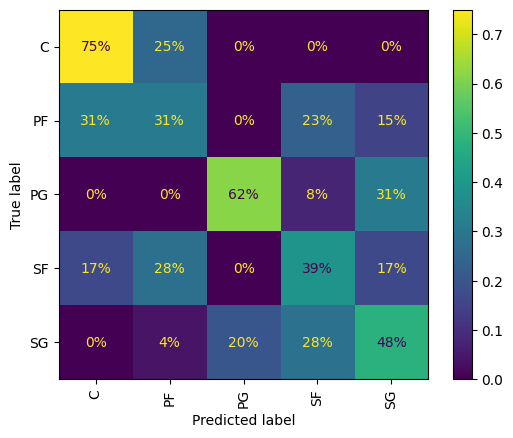

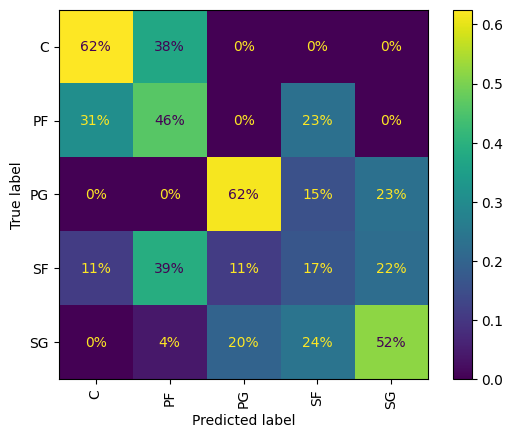

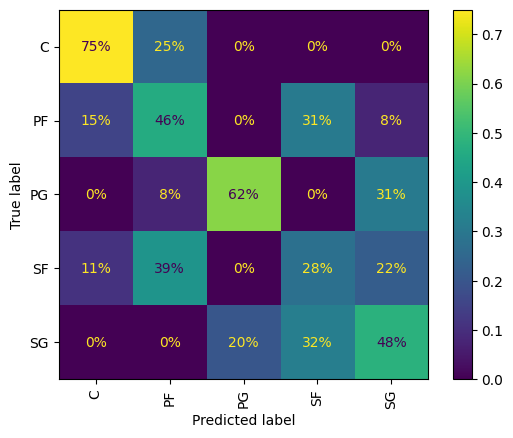

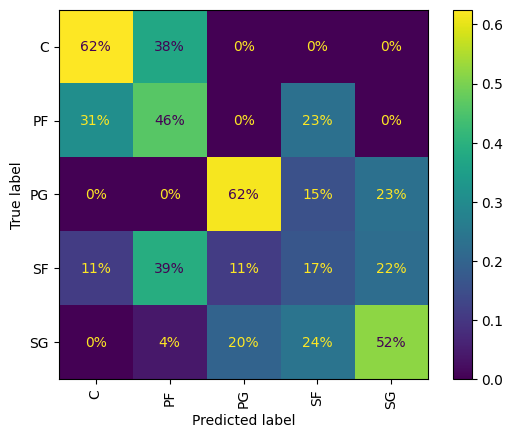

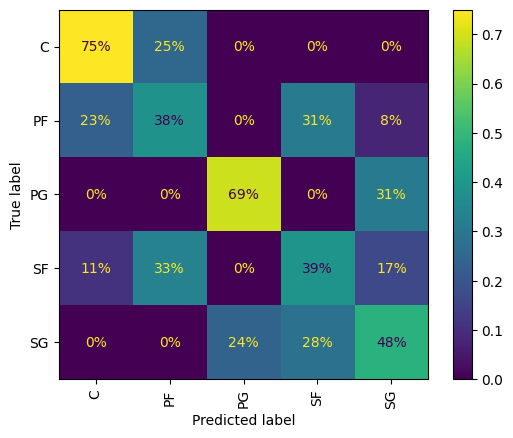

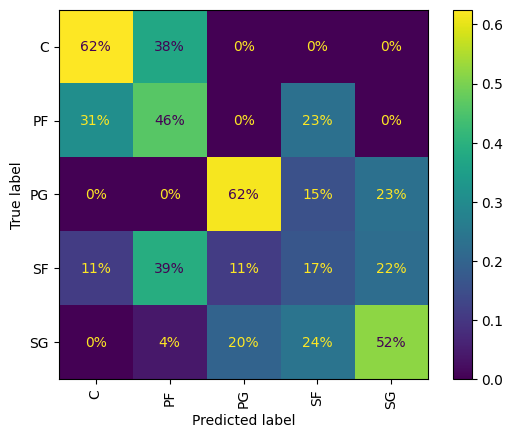

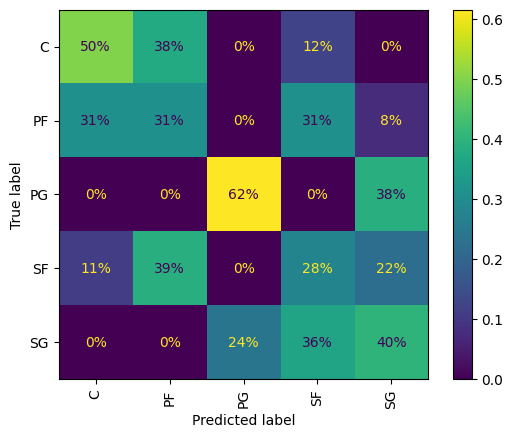

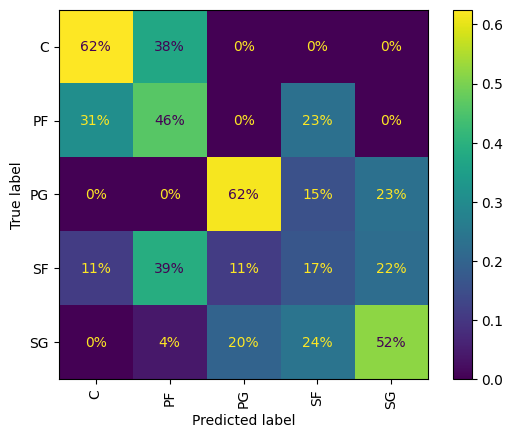

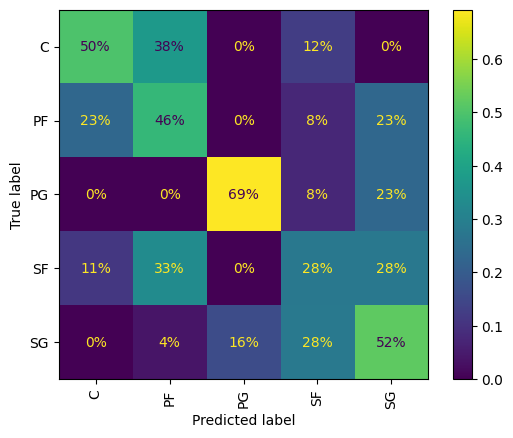

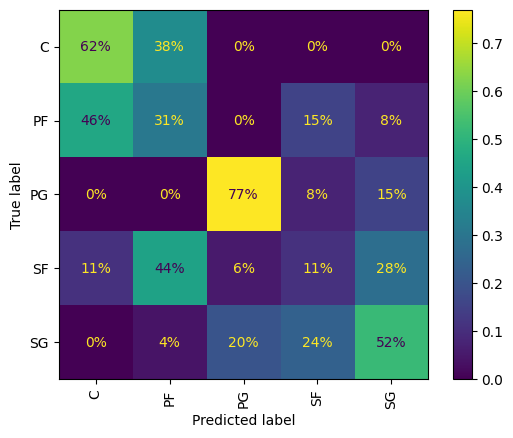

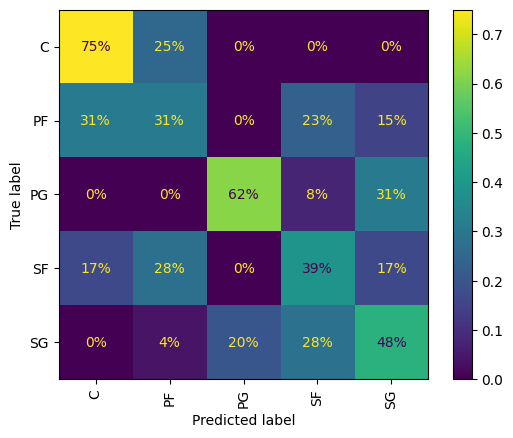

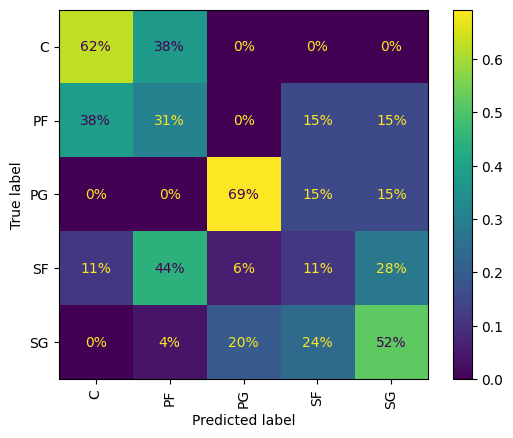

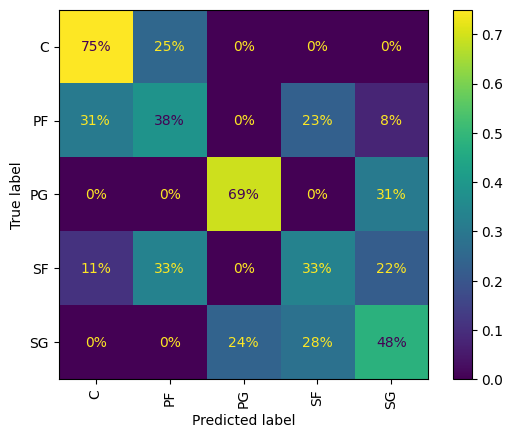

In [23]:
# Split features and target variables
top_features = ['Assists', 'Avg_Rebound', 'TotalRebound', 'OffensiveRebound',
       '2points%', 'Blocks', 'DenffesiveRebound', 'Field_goal%_squared',
       'Field_goal%', 'Rolling_Points_Avg', 'TurnOver', 'PersonalFoul',
       'Rolling_Assists_Max', '3points%', 'Steal', 'FreeThrow%',
       'Points_per_Minute', 'Points', 'Cross_3points_scored_assist',
       '2points_assits', 'Age', '3points_Assists', 'OffensiveRating',
       '3points_scored', 'Game_Started', 'FreeThrow',
       'Cross_2points_scored_assist', 'Goal_attempt', 'N_Games',
       'FreeThrowAttempt', 'Minute_played', 'DeffensiveRating', 'Ratings',
       '2points_scored']

X = filtered_data[top_features]
y = filtered_data['Position']


# Split the data before any preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create pipelines for each classifier to eliminate data leakage 
svc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(class_weight='balanced', random_state=42))
])

rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Define classifiers
classifiers = {
    'SVC': svc_pipeline,
    'RandomForestClassifier': rf_pipeline
}

# Define hyperparameters
params = {
    'SVC': {
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__degree': [1, 2, 3, 4],
        'svc__C': [1, 10, 100, 200, 300],
        'svc__gamma': [0.1, 0.01, 0.001, 1]
    },
    'RandomForestClassifier': {
        'rf__n_estimators': [1, 10, 100, 200, 500, 600],
        'rf__max_depth': [10, 50, 100, 200, 400, 500],
        'rf__bootstrap': [True],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__criterion': ['gini', 'entropy']
    }
}
# Define different KFold strategies
kfold_strategies = {
    'StratifiedKFold_3': StratifiedKFold(n_splits=3),
    'StratifiedKFold_5': StratifiedKFold(n_splits=5),
    'StratifiedKFold_10': StratifiedKFold(n_splits=10),
    'StratifiedKFold_20': StratifiedKFold(n_splits=20),
    'KFold_3': KFold(n_splits=3, shuffle=True, random_state=42),
    'KFold_5': KFold(n_splits=5, shuffle=True, random_state=42),
    'KFold_10': KFold(n_splits=10, shuffle=True, random_state=42),
    'KFold_20': KFold(n_splits=20, shuffle=True, random_state=42)
}

# Perform cross-validation and grid search
for kfold_name, kfold_strategy in kfold_strategies.items():
    print(f'Using KFold strategy: {kfold_name}')

    for name, clf in classifiers.items():
        print(f'Classifier: {name}')
        grid_best_model = GridSearchCV(estimator=clf, param_grid=params[name], scoring='accuracy', n_jobs=-1, 
                                        cv=kfold_strategy, verbose=1)

        grid_best_model.fit(X_train, y_train)

        y_pred = grid_best_model.predict(X_test)

        print(f'Best Score: {grid_best_model.best_score_}')
        print(f'Best Parameters: {grid_best_model.best_params_}')

        metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%", xticks_rotation='vertical')
        print(metrics.classification_report(y_test, y_pred))
        print('-' * 75)

              precision    recall  f1-score   support

           C       0.45      0.62      0.53         8
          PF       0.35      0.46      0.40        13
          PG       0.53      0.62      0.57        13
          SF       0.21      0.17      0.19        18
          SG       0.65      0.52      0.58        25

    accuracy                           0.45        77
   macro avg       0.44      0.48      0.45        77
weighted avg       0.46      0.45      0.45        77



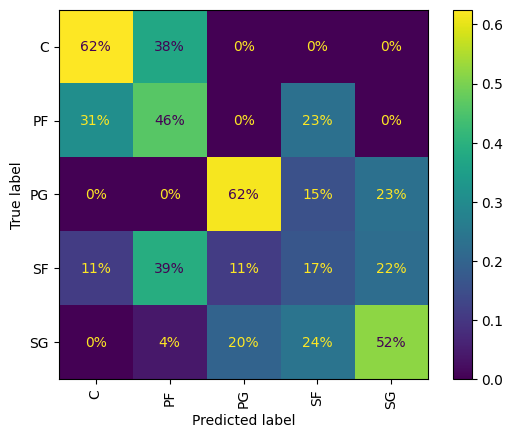

In [24]:
# Define the SVC model with specified parameters
svc_model = SVC(C=10, degree=1, gamma=0.001, kernel='rbf', class_weight='balanced', random_state=42)

# Define the pipeline with scaler, SMOTE, and SVC
svc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', svc_model)
])

# Fit the pipeline with the training data
svc_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = svc_pipeline.predict(X_test)

# Display the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%", xticks_rotation='vertical')
print(metrics.classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/L

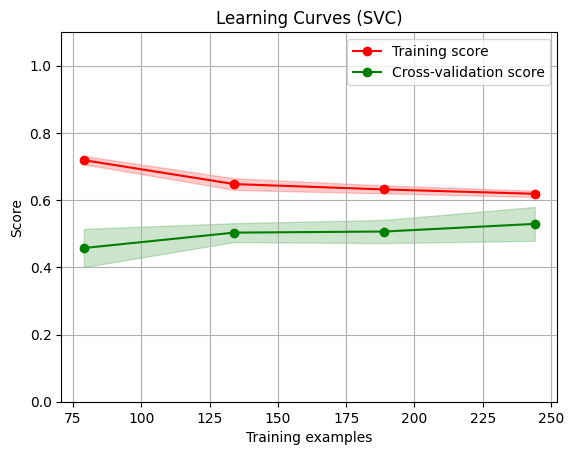

In [25]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(svc_pipeline, X_train, y_train, cv=5, n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves (SVC)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

# Sample test sets

In [26]:
# Create a sample dataset and put it on a DataFrame
data = {
    'Assists': [4.37, 9.56, 7.59],
    'Avg_Rebound': [6.39, 2.40, 2.40],
    'TotalRebound': [2.10, 17.46, 12.42],
    'OffensiveRebound': [7.23, 0.70, 9.71],
    '2points%': [0.550, 0.364, 0.355],
    'Blocks': [0.37, 0.61, 1.05],
    'DenffesiveRebound': [4.89, 3.62, 6.51],
    'Field_goal%_squared': [0.128, 0.158, 0.173],
    'Field_goal%': [0.391, 0.457, 0.340],
    'Rolling_Points_Avg': [10.28, 11.85, 0.93],
    'TurnOver': [2, 3, 1],
    'PersonalFoul': [3, 2, 4],
    'Rolling_Assists_Max': [14, 12, 15],
    '3points%': [0.35, 0.45, 0.40],
    'Steal': [2.1, 1.8, 2.4],
    'FreeThrow%': [0.65, 0.75, 0.70],
    'Points_per_Minute': [0.50, 0.40, 0.55],
    'Points': [12, 20, 18],
    'Cross_3points_scored_assist': [5, 7, 6],
    '2points_assits': [3, 4, 6],
    'Age': [25, 22, 30],
    '3points_Assists': [4, 3, 4],
    'OffensiveRating': [107, 104, 108],
    '3points_scored': [3, 5, 7],
    'Game_Started': [6, 8, 23],
    'FreeThrow': [1.79, 1.59, 1.03],
    'Cross_2points_scored_assist': [3, 1, 8],
    'Goal_attempt': [15.94, 16.57, 6.11],
    'N_Games': [16, 35, 18],
    'FreeThrowAttempt': [4.66, 4.40, 2.80],
    'Minute_played': [12.86, 21.12, 30.07],
    'DeffensiveRating': [107, 104, 91],
    'Ratings': [21, 18, 29],
    '2points_scored': [3, 1, 5]
}

test_set = pd.DataFrame(data)

In [27]:
# Predict labels for the new test data
y_testset_pred = svc_pipeline.predict(test_set)

print(f'Predicted Labels are: {y_testset_pred}')

Predicted Labels are: ['SG' 'PG' 'PF']
